### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project






In [23]:
"""I need to predict which costumers will purchase a cog based on their characteristics. 
The characteristics given include gender, age, and salary. The company needs to find their ideal customer profile (ICP) to optimize their sales.   """

'I need to predict which costumers will purchase a cog based on their characteristics. \nThe characteristics given include gender, age, and salary. The company needs to find their ideal customer profile (ICP) to optimize their sales.   '

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)



In [16]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
df=pd.read_csv("Project_3.csv")

"""
The data was provided to me by the teacher. It is in the form of a csv with UserID, name, gender age, salery, and whether they purchased the product. The data contains 1000 rows.
"""

'\nThe data was provided to me by the teacher. It is in the form of a csv with UserID, name, gender age, salery, and whether they purchased the product. The data contains 1000 rows.\n'

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

{'shape': (1001, 6), 'missing': {'User ID': 0, 'name': 0, 'Gender': 0, 'Age': 0, 'EstimatedSalary': 0, 'Purchased': 0}, 'class_counts': {1: 433, 0: 527, -1: 41}, 'gender_table': {1: {'Female': 238, 'Male': 195}, 0: {'Female': 276, 'Male': 251}, -1: {'Female': 21, 'Male': 20}}}


"\nAfter manually looking through the data, I noticed that the gender column seemed to be mismatched. \nA lot of the names were marked as male for names that were seemingly female, and vice versa.\nAdditionally, the highest number of people did not purchase the product, and the fewest number of people returned it (-1). \nThe most interesting aspect of the data that I noticed was that the boxplots (the first quartile specifically) for the salary seemed to have some correlation whether a customer purchased the product. \nFor the customers that didn't buy the product Q1 and the median was the lowest, then the customers that returned the item took second place, and finally the customers that purchased the product had the highest median and Q1. \nTherefore, I plan on exponentiating the data to see if that feature can help me predict whether someone will purchase a product. \n"

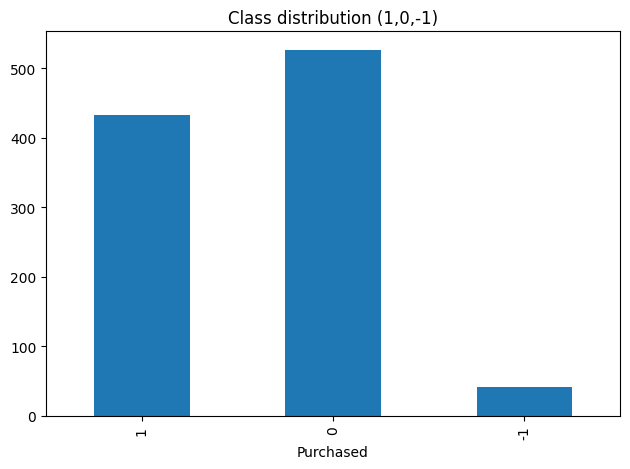

<Figure size 640x480 with 0 Axes>

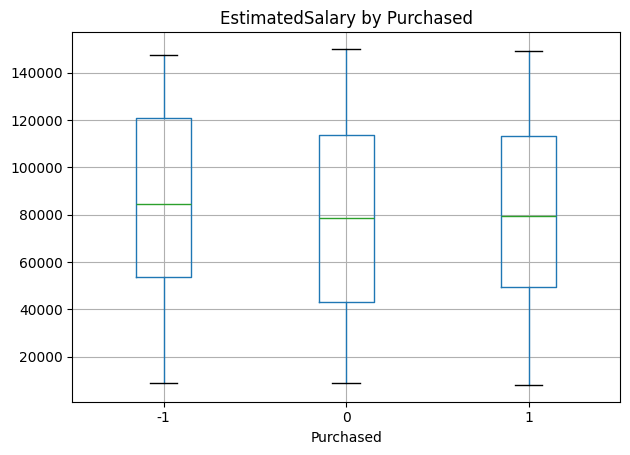

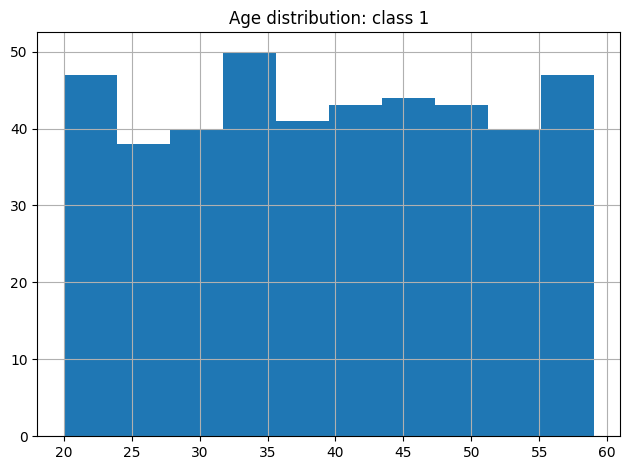

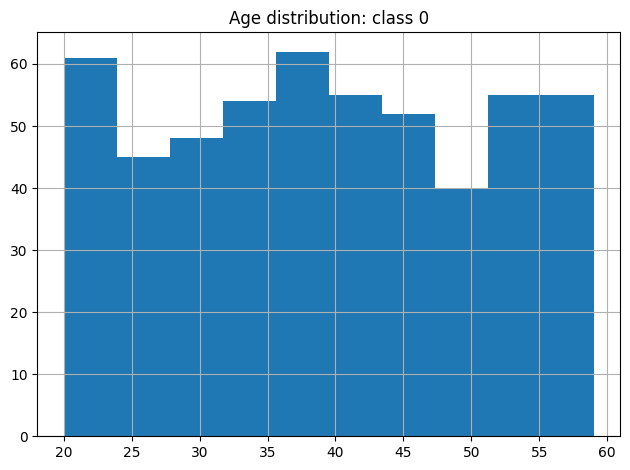

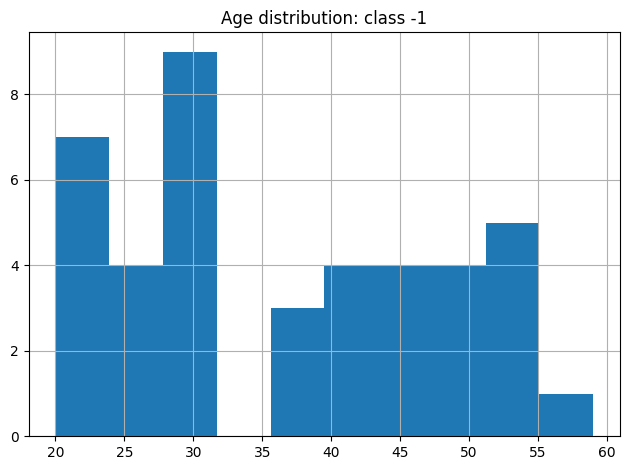

In [17]:
shape=df.shape

missing=df.isna().sum()

class_counts=df["Purchased"].value_counts().reindex([1,0,-1],fill_value=0)

gender_ct=df.pivot_table(index="Gender",columns="Purchased",values="User ID",aggfunc="count").reindex(columns=[1,0,-1],fill_value=0).fillna(0)

print({"shape":shape,"missing":missing.to_dict(),"class_counts":class_counts.to_dict(),"gender_table":gender_ct.to_dict()})

plt.figure(); class_counts.plot(kind="bar"); plt.title("Class distribution (1,0,-1)"); plt.tight_layout()

plt.figure(); df.boxplot(column="EstimatedSalary",by="Purchased"); plt.suptitle(""); plt.title("EstimatedSalary by Purchased"); plt.tight_layout()

for c in [1,0,-1]:
    plt.figure(); df.loc[df["Purchased"]==c,"Age"].hist(bins=10); plt.title(f"Age distribution: class {c}"); plt.tight_layout()

"""
After manually looking through the data, I noticed that the gender column seemed to be mismatched. 
A lot of the names were marked as male for names that were seemingly female, and vice versa.
Additionally, the highest number of people did not purchase the product, and the fewest number of people returned it (-1). 
The most interesting aspect of the data that I noticed was that the boxplots (the first quartile specifically) for the salary seemed to have some correlation whether a customer purchased the product. 
For the customers that didn't buy the product Q1 and the median was the lowest, then the customers that returned the item took second place, and finally the customers that purchased the product had the highest median and Q1. 
Therefore, I plan on exponentiating the data to see if that feature can help me predict whether someone will purchase a product. 
"""


# 4.Prepare the Data


Apply any data transformations and explain what and why


In [55]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


# drop id/name
drop_cols = [c for c in df.columns if c.strip().lower() in {"user id","userid","user_id","name","customername"}]
df = df.drop(columns=drop_cols, errors="ignore")

# build targets
target_col = next((c for c in ["OutcomeClass","Purchased","purchased","target","Outcome","Label","y"] if c in df.columns), None)

y_raw = df[target_col].astype(int).replace({-1: 2})  # 0 no 1 yes 2 returned
df["is_NotPurchased"] = (y_raw == 0).astype(int)
df["is_Purchased"]    = (y_raw == 1).astype(int)
df["is_Returned"]     = (y_raw == 2).astype(int)
df["OutcomeClass"]    = y_raw.values

# features we actually use
features = ["Age","EstimatedSalary","Gender"]
if any(f not in df.columns for f in features):
    missing = [f for f in features if f not in df.columns]
    raise RuntimeError(f"Missing required feature(s): {missing}")
X = df[features].copy()
y = df["OutcomeClass"].values

# split 80 20 keep class balance
Xtr_raw, Xte_raw, ytr, yte = train_test_split(X, y, test_size=0.20, random_state=1337, stratify=y)

# preprocess median then z score for nums mode then one hot for cats
num_cols = [c for c in features if X[c].dtype != "object"]
cat_cols = [c for c in features if X[c].dtype == "object"]
pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore", drop="first"))]), cat_cols),
])

# fit on train only
Xtr = pre.fit_transform(Xtr_raw)
Xte = pre.transform(Xte_raw)
"""
I removed user id and name since they do not help. 
I created three target columns: is NotPurchased, is Purchased, is Returned, and a single multiclass label. 
I trained only on Age, EstimatedSalary, and Gender. 
I filled missing values, median for numbers, and most frequent for categories. 
I z-score scaled the numeric features and one-hot encoded the categorical features. 
I used an 80/20 train-test split with a fixed random state.
"""

'\nI removed user id and name since they do not help. \nI created three target columns: is NotPurchased, is Purchased, is Returned, and a single multiclass label. \nI trained only on Age, EstimatedSalary, and Gender. \nI filled missing values, median for numbers, and most frequent for categories. \nI z-score scaled the numeric features and one-hot encoded the categorical features. \nI used an 80/20 train-test split with a fixed random state.\n'

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [56]:
import numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score

# use the raw train test from step 4
num_cols = [c for c in Xtr_raw.columns if Xtr_raw[c].dtype != "object"]
cat_cols = [c for c in Xtr_raw.columns if Xtr_raw[c].dtype == "object"]

def add_num_feats_np(A, num_cols=num_cols):
    # small feature bump log salary squares and a couple interactions
    A = np.asarray(A, dtype=float)
    outs = [A]
    idx = {c:i for i,c in enumerate(num_cols)}
    if "EstimatedSalary" in idx:
        s = A[:, idx["EstimatedSalary"]]
        outs.append(np.log1p(s).reshape(-1,1))
        outs.append((s**2).reshape(-1,1))
    if "Age" in idx:
        a = A[:, idx["Age"]]
        outs.append((a**2).reshape(-1,1))
        if "EstimatedSalary" in idx:
            outs.append((a*np.log1p(s)).reshape(-1,1))
            outs.append((a*s).reshape(-1,1))
    return np.hstack(outs)

# numeric impute add feats z score
num_cont = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("fe", FunctionTransformer(add_num_feats_np, validate=False)),
    ("sc", StandardScaler())
])

# bins help linear models catch nonlinearity
num_bins = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("kb", KBinsDiscretizer(n_bins=5, encode="onehot-dense", strategy="quantile"))
])

# categorical mode then one hot
cat_block = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

pre = ColumnTransformer([
    ("num_cont", num_cont, num_cols),
    ("num_bins", num_bins, num_cols),
    ("cat", cat_block, cat_cols),
])

models = {
    "LogReg": Pipeline([("prep", pre), ("m", LogisticRegression(max_iter=8000, multi_class="auto"))]),
    "GBC":    Pipeline([("prep", pre), ("m", GradientBoostingClassifier(random_state=1337))]),
    "HGB":    Pipeline([("prep", pre), ("m", HistGradientBoostingClassifier(random_state=1337))]),
    "RF":     Pipeline([("prep", pre), ("m", RandomForestClassifier(random_state=1337, n_jobs=-1))]),
}

rows = []
for name, pipe in models.items():
    pipe.fit(Xtr_raw, ytr)
    p = pipe.predict(Xte_raw)
    rows.append({
        "model": name,
        "accuracy": float(accuracy_score(yte, p)),
        "f1_macro": float(f1_score(yte, p, average="macro"))
    })

bench = pd.DataFrame(rows).sort_values(["accuracy","f1_macro"], ascending=False).reset_index(drop=True)
print(bench)
"""
I compared multinomial logistic regression, random forest, histogram gradient boosting, and gradient boosting. 
I scored with accuracy and macro F1. 
I added a few features including log of salary, age squared, and salary squared, and I also added quantile bins for age and salary. 
This pushed accuracy up a few points.
GBC and LogReg tied on accuracy in my split so I moved forward with GBC for tuning since it had a higher macro F1.
"""

/opt/tljh/user/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


    model  accuracy  f1_macro
0     GBC  0.532338  0.355345
1  LogReg  0.532338  0.349650
2     HGB  0.502488  0.341244
3      RF  0.487562  0.332087


'\nI compared multinomial logistic regression, random forest, histogram gradient boosting, and gradient boosting. \nI scored with accuracy and macro F1. \nI added a few features including log of salary, age squared, and salary squared, and I also added quantile bins for age and salary. \nThis pushed accuracy up a few points.\nGBC and LogReg tied on accuracy in my split so I moved forward with GBC for tuning since it had a higher macro F1.\n'

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [57]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
from pathlib import Path
import json, joblib

ARTIFACT_DIR = Path("./artifacts"); ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = ARTIFACT_DIR / "model_cog_gbc.joblib"
META_PATH  = ARTIFACT_DIR / "meta_cog_gbc.json"
RANDOM_STATE = 1337

gbc = Pipeline([("prep", pre), ("m", GradientBoostingClassifier(random_state=RANDOM_STATE))])

param_dist = {
    "m__learning_rate": loguniform(1e-2, 2e-1),
    "m__n_estimators": randint(300, 900),
    "m__max_depth": randint(1, 4),
    "m__min_samples_leaf": randint(1, 11),
    "m__min_samples_split": randint(2, 21),
    "m__subsample": uniform(0.7, 0.3),
    "m__max_features": ["sqrt", None],
}

search = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=60,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0
)
search.fit(Xtr_raw, ytr)

best = search.best_estimator_
pred = best.predict(Xte_raw)
metrics = {"accuracy": float(accuracy_score(yte, pred)),
           "f1_macro": float(f1_score(yte, pred, average="macro"))}
print({"test_metrics": metrics, "best_params": search.best_params_})

# refit and persist
X_all = pd.concat([Xtr_raw, Xte_raw], axis=0)
y_all = np.concatenate([ytr, yte], axis=0)
final = best.fit(X_all, y_all)
joblib.dump(final, MODEL_PATH)
META_PATH.write_text(json.dumps({
    "features": list(Xtr_raw.columns),
    "chosen_model": "GradientBoostingClassifier",
    "best_params": search.best_params_,
    "metrics": metrics,
    "class_names": {"0":"NotPurchased","1":"Purchased","2":"Returned"}
}, indent=2))

"""
I tuned gradient boosting for accuracy using randomized five fold cross validation. 
I searched learning rate number of trees depth leaf size split size row subsampling and feature subsampling. 
Then I evaluated on the test split and refit on all data. 
Finally, I saved the full pipeline and a small meta file for inference for step 8.
"""


{'test_metrics': {'accuracy': 0.5671641791044776, 'f1_macro': 0.3478618421052631}, 'best_params': {'m__learning_rate': 0.0194661306376966, 'm__max_depth': 1, 'm__max_features': 'sqrt', 'm__min_samples_leaf': 5, 'm__min_samples_split': 6, 'm__n_estimators': 430, 'm__subsample': 0.7144705295684427}}


'\nI tuned gradient boosting for accuracy using randomized five fold cross validation. \nI searched learning rate number of trees depth leaf size split size row subsampling and feature subsampling. \nThen I evaluated on the test split and refit on all data. \nFinally, I saved the full pipeline and a small meta file for inference for step 8.\n'

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


In [60]:
"""
My goal is to help the sales team target prospects most likely to buy, and keep, a Cog. 
I cleaned the emailed data, removed IDs and names, and kept only fields we know before outreach: Age, EstimatedSalary, and Gender. 
I built three target columns, NotPurchased, Purchased, and Returned, and trained a single multiclass label. 
Missing values were imputed, numerics were standardized, and categoricals were one-hot encoded.
I used an 80/20 stratified split.

I compared multinomial Logistic Regression, Random Forest, Histogram Gradient Boosting, and Gradient Boosting. 
After adding a few simple, leakage-safe features, then tuning Gradient Boosting, the final model reached 56.7% accuracy and 0.348 macro-F1 on the test set. 
How to use:
Call the function name infrence with three arguments in this order:
age as a number
estimated_salary as a number in dollars
gender as text such as Male or Female

Example call:
infrence(age=35, estimated_salary=72000, gender="Female")

"""

'\nMy goal is to help the sales team target prospects most likely to buy, and keep, a Cog. \nI cleaned the emailed data, removed IDs and names, and kept only fields we know before outreach: Age, EstimatedSalary, and Gender. \nI built three target columns, NotPurchased, Purchased, and Returned, and trained a single multiclass label. \nMissing values were imputed, numerics were standardized, and categoricals were one-hot encoded.\nI used an 80/20 stratified split.\n\nI compared multinomial Logistic Regression, Random Forest, Histogram Gradient Boosting, and Gradient Boosting. \nAfter adding a few simple, leakage-safe features, then tuning Gradient Boosting, the final model reached 56.7% accuracy and 0.348 macro-F1 on the test set. \nHow to use:\nCall the function name infrence with three arguments in this order:\nage as a number\nestimated_salary as a number in dollars\ngender as text such as Male or Female\n\nExample call:\ninfrence(age=35, estimated_salary=72000, gender="Female")\n\n'

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [61]:
def infrence(age: float, estimated_salary: float, gender: str):
    import pandas as pd, joblib, json
    from pathlib import Path
    import numpy as np
    p = Path("./artifacts")
    m = joblib.load(p / "model_cog_gbc.joblib")
    meta = json.loads((p / "meta_cog_gbc.json").read_text())
    X = pd.DataFrame([{"Age": age, "EstimatedSalary": estimated_salary, "Gender": gender}], columns=meta["features"])
    proba = m.predict_proba(X)[0]
    pred_idx = int(np.argmax(proba))
    name_map = {int(k): v for k, v in meta["class_names"].items()}
    return {
        "predicted_class": name_map.get(pred_idx, str(pred_idx)),
        "class_probabilities": {name_map.get(i, str(i)): float(p) for i, p in enumerate(proba)}
    }

print(infrence(age=35, estimated_salary=72000, gender="Female"))

{'predicted_class': 'NotPurchased', 'class_probabilities': {'NotPurchased': 0.5901359806725858, 'Purchased': 0.37885406102211, 'Returned': 0.031009958305304227}}
